# A

In [30]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize
from transformer_architecture_elements import Time2Vector, SingleAttention, MultiAttention, TransformerEncoder

In [31]:
filename = 'Benchmark/trained_models/LSTM_univariate2_classification____0100.hdf5'  # Classification model
# filename = 'Benchmark/trained_models/LSTM_univariate2_with_close_price____0150.hdf5'  # Regression model
# filename = 'content/Transformer+TimeEmbedding2_minmax____0300.hdf5'

my_LSTM_model = tf.keras.models.load_model(
    filename,
    custom_objects={
        'kl_divergence': kullback_leibler_divergence,
        'Time2Vector': Time2Vector,
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)
lag = my_LSTM_model.input_shape[1]
print(f'lag: {lag}')
if my_LSTM_model.layers[-1].activation == tf.keras.activations.softmax:
    nn_type_classification = True
    h = 1
else:
    nn_type_classification = False
    h = my_LSTM_model.output_shape[1]
print(f'h: {h}')

lag: 128
h: 1


In [32]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [33]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')

df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'EURUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)

df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [34]:
def strategy(x):
    conditions = [
        (x <= -0.00000001),
        (x > -0.00000001) & (x <= 0.00000001),
        (x > 0.00000001)
    ]

    # create a list of the values we want to assign for each condition #!!! 
    values = ['sell', 'hold', 'buy']
    values = [0, 1, 2]

    # create a new column and use np.select to assign values to it using our lists as arguments #!!! 
    return np.select(conditions, values).astype(np.int32)
df['strategy'] = strategy(df[target])

df.head()

,EURUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,0.000275,2
2020-11-01 19:30:00,-0.000069,0
2020-11-01 19:40:00,0.000034,2
2020-11-01 19:50:00,0.000026,2


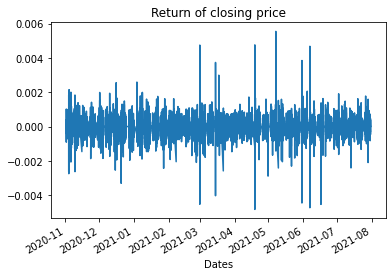

In [35]:
df[target].plot()
plt.title('Return of closing price')
plt.show()

In [28]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, 1)

In [29]:
if nn_type_classification:
    y_train = sc_target.inverse_transform(y_train)
    y_val = sc_target.inverse_transform(y_val)
    y_test = sc_target.inverse_transform(y_test)

## Econmetric measures

Definition of cumulated returns

In [10]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

In [11]:
#!!! for testing purposes
tmp_type = 'train'

X = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)
for i in range(lag):
    diff = np.abs(df.loc[eval(f"index_{tmp_type}")].iloc[i:-(lag - i + 1)].values - X[:,-(lag - i)]).sum(axis=0)
    assert diff[0] < 1e-6 and diff[1] < 0.5, 'df and X inversed are not the same'

X_ret_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 0]
y_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]

a = sc_target.inverse_transform(eval(f"y_{tmp_type}")).flatten()
b = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]
cc = df.loc[eval(f"index_{tmp_type}")].iloc[(lag - 1):-(h+1), 1].values
print(np.abs(cc[1:] - a[:-1]).sum(axis=0))
print(np.abs(cc - b).sum(axis=0))

23012.36448711349
0.0


In [12]:
print((index_train[0:-(lag+1)] == X_train_index[:, 0]).all())
print((index_train[(lag-1):-(h+1)] == X_train_index[:, -1]).all())

True
True


## read in data for econmic metric

In [13]:
def econ_metrics(y_pred, X_ret, risk_free=0.0031):  # Risk free rate must be given
    x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)
    print(f'Portfolio return: {x[-1] / x[0] - 1}')
    print(f'Std of returns: {np.std(x[1:] / x[:-1])}')
    print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
    print()
    
    n = 6 * 24 * 252  # banking days per year
    mu_annum = ((x[-1]/x[0]) ** (n / x.shape[0])) - 1
    print(f'Return per annum: {mu_annum}')
    std_annum = np.std(x[1:] / x[:-1]) * (n)**0.5
    print(f'Std of returns per annum: {std_annum}')
    print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')

In [17]:
def result_output2(tmp_type):
    print(tmp_type)

    y = eval(f"y_{tmp_type}")
    if nn_type_classification:
        y_pred = np.argmax(predictions(
            my_LSTM_model,
            eval(f"X_{tmp_type}")
        ), axis=1)
    else:
        y_pred = strategy(predictions(
            my_LSTM_model,
            eval(f"X_{tmp_type}")
        ))
    print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
    print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
    print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
    plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

    p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
    x = np.concatenate(
        [
            cumulated_return(
                np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
                X_ret[1:],
                dtype=dtype
            )[:,np.newaxis] for i in range(50)
        ], axis=-1
    )2.35444876995291
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
    plt.legend()
    plt.semilogy()
    plt.show()
    econ_metrics(y_pred, X_ret)

train
Accuracy: 0.6982366442680359
Accuracy: 0.4709501266479492
KL_Divergence: 52174.26953125
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68     10870
         1.0       0.94      0.85      0.89       926
         2.0       0.69      0.72      0.70     11285

    accuracy                           0.70     23081
   macro avg       0.77      0.74      0.76     23081
weighted avg       0.70      0.70      0.70     23081



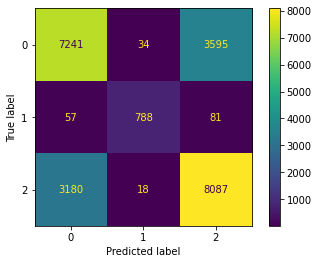

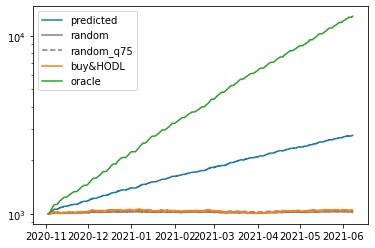

Portfolio return: 1.7589056491851807
Std of returns: 0.00023904646513983607
Sharpe ratio: 7358.0073570896175

Return per annum: 3.869202345504556
Std of returns per annum: 0.04535587778723537
Sharpe ratio per annum: 85.30762790337786


In [18]:
result_output2('train')

val
Accuracy: 0.49639248847961426
Accuracy: 0.4942280054092407
KL_Divergence: 10605.7060546875
              precision    recall  f1-score   support

         0.0       0.50      0.49      0.50      1370
         1.0       0.44      0.17      0.25        82
         2.0       0.49      0.53      0.51      1320

    accuracy                           0.50      2772
   macro avg       0.48      0.39      0.42      2772
weighted avg       0.50      0.50      0.49      2772



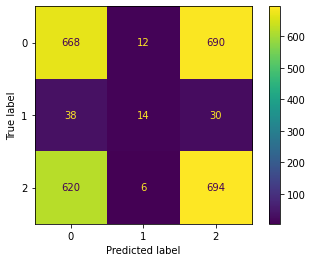

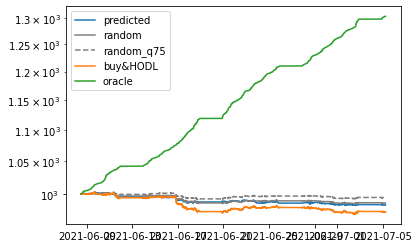

Portfolio return: -0.015884339809417725
Std of returns: 0.00021069037029519677
Sharpe ratio: -75.39186431331574

Return per annum: -0.18781011815960302
Std of returns per annum: 0.039975687071826256
Sharpe ratio per annum: -4.698108573397512


In [19]:
result_output2('val')

test
Accuracy: 0.47330448031425476
Accuracy: 0.47330448031425476
KL_Divergence: 11459.96484375
              precision    recall  f1-score   support

         0.0       0.46      0.46      0.46      1312
         1.0       0.34      0.17      0.23        75
         2.0       0.49      0.50      0.50      1385

    accuracy                           0.47      2772
   macro avg       0.43      0.38      0.40      2772
weighted avg       0.47      0.47      0.47      2772



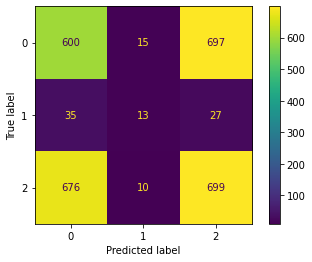

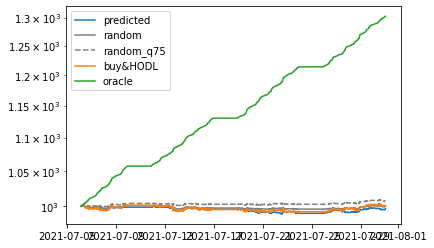

Portfolio return: -0.0035047531127929688
Std of returns: 0.00020129921904299408
Sharpe ratio: -17.410664231362038

Return per annum: -0.04458805691318535
Std of returns per annum: 0.03819384140334008
Sharpe ratio per annum: -1.1674148311587764


In [20]:
result_output2('test')